# Additional Analysis: No-Mortality Predictors

This notebook addresses the reviewer request by removing mortality-related predictors and re-running the analysis with non-mortality variables only.

## What is excluded as bias-prone/tautological here
- `adult_mortality_15_60`
- `u5_mortality_rate`
- `infant_deaths`
- `log_infant_deaths`

The goal is to evaluate which **other** indicators still explain life expectancy and how strong their contributions are.


## 1) Imports and Paths

In [81]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

sns.set_theme(style='whitegrid')
RANDOM_STATE = 42

# Resolve project root whether run from repo root or Codes/
CWD = Path.cwd().resolve()
if (CWD / 'Assets' / 'cleaner_exports').exists():
    PROJECT_ROOT = CWD
elif (CWD.parent / 'Assets' / 'cleaner_exports').exists():
    PROJECT_ROOT = CWD.parent
else:
    PROJECT_ROOT = CWD

DATA_DIR = PROJECT_ROOT / 'Assets' / 'cleaner_exports'
FULL_PATH = DATA_DIR / 'health_panel_ml_numeric.csv'

if not FULL_PATH.exists():
    raise FileNotFoundError(f'Missing required file: {FULL_PATH.resolve()}')

TARGET_CANDIDATES = ['life_expectancy', 'Life expectancy', 'life expectancy']
YEAR_CANDIDATES = ['Year', 'year']
COUNTRY_CANDIDATES = ['Country', 'country', 'Nation']
REGION_CANDIDATES = ['Region', 'region', 'Continent', 'continent', 'WHO_region', 'IncomeGroup']

IMAGES_DIR = PROJECT_ROOT / 'Images'
EXPORT_DIR = PROJECT_ROOT / 'cleaner_exports'
IMAGES_DIR.mkdir(parents=True, exist_ok=True)
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

print('Project root:', PROJECT_ROOT)
print('Data dir    :', DATA_DIR)
print('Images dir  :', IMAGES_DIR)
print('Export dir  :', EXPORT_DIR)


Project root: /Users/bikki/Documents/Projects_Spring_2026/STATS201
Data dir    : /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports
Images dir  : /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images
Export dir  : /Users/bikki/Documents/Projects_Spring_2026/STATS201/cleaner_exports


## 2) Load Data

In [82]:
full_df = pd.read_csv(FULL_PATH)


def pick_col(df, candidates, contains_hint=None):
    for col in candidates:
        if col in df.columns:
            return col
    if contains_hint:
        low = {c.lower(): c for c in df.columns}
        for hint in contains_hint:
            for lc, orig in low.items():
                if hint in lc:
                    return orig
    return None


TARGET = pick_col(full_df, TARGET_CANDIDATES, contains_hint=['life', 'expect'])
YEAR_COL = pick_col(full_df, YEAR_CANDIDATES, contains_hint=['year'])
COUNTRY_COL = pick_col(full_df, COUNTRY_CANDIDATES, contains_hint=['country'])
REGION_COL = pick_col(full_df, REGION_CANDIDATES, contains_hint=['region', 'continent', 'income'])

if TARGET is None:
    raise ValueError('Target column not found. Tried life expectancy variants.')
if YEAR_COL is None:
    raise ValueError('Year column not found. Tried Year/year variants.')
if COUNTRY_COL is None:
    raise ValueError('Country identifier column not found. Tried Country/country variants.')

full_df[YEAR_COL] = pd.to_numeric(full_df[YEAR_COL], errors='coerce')

train_df = full_df[(full_df[YEAR_COL] >= 2000) & (full_df[YEAR_COL] <= 2017)].copy()
test_df = full_df[(full_df[YEAR_COL] >= 2018) & (full_df[YEAR_COL] <= 2021)].copy()

if train_df.empty or test_df.empty:
    raise ValueError('Train/test split is empty. Check Year coverage for 2000-2021 window.')

print('Detected columns ->')
print('  Target :', TARGET)
print('  Year   :', YEAR_COL)
print('  Country:', COUNTRY_COL)
print('  Region :', REGION_COL if REGION_COL is not None else 'None found')

print('Full shape :', full_df.shape)
print('Train shape:', train_df.shape)
print('Test shape :', test_df.shape)
print('Train years:', int(train_df[YEAR_COL].min()), '-', int(train_df[YEAR_COL].max()))
print('Test years :', int(test_df[YEAR_COL].min()), '-', int(test_df[YEAR_COL].max()))
print('Row counts -> full:', len(full_df), '| train:', len(train_df), '| test:', len(test_df))


Detected columns ->
  Target : life_expectancy
  Year   : Year
  Country: Country
  Region : None found
Full shape : (4224, 19)
Train shape: (3456, 19)
Test shape : (768, 19)
Train years: 2000 - 2017
Test years : 2018 - 2021
Row counts -> full: 4224 | train: 3456 | test: 768


## 3) Define No-Mortality Feature Sets

In [83]:
bias_mortality_vars = [
    'adult_mortality_15_60',
    'u5_mortality_rate',
    'infant_deaths',
    'log_infant_deaths',
]

# Core non-mortality variables
no_mortality_base = [
    'alcohol_per_capita_15plus',
    'che_pct_gdp',
    'hepb3_coverage_pct',
    'pol3_coverage_pct',
    'dtp3_coverage_pct',
    'gdp_per_capita_2015usd',
    'overweight_adults_pct',
    'underweight_adults_pct',
    'thinness_children_adolescents_pct',
]

# Engineered (domain transform) variant without mortality variables
no_mortality_engineered = [
    'alcohol_per_capita_15plus',
    'che_pct_gdp',
    'hepb3_coverage_pct',
    'pol3_coverage_pct',
    'dtp3_coverage_pct',
    'log_gdp_per_capita_2015usd',
    'overweight_adults_pct',
    'underweight_adults_pct',
    'thinness_children_adolescents_pct',
]

print('Excluded variables:', bias_mortality_vars)
print('No-mortality base features      :', len(no_mortality_base))
print('No-mortality engineered features:', len(no_mortality_engineered))


Excluded variables: ['adult_mortality_15_60', 'u5_mortality_rate', 'infant_deaths', 'log_infant_deaths']
No-mortality base features      : 9
No-mortality engineered features: 9


## 4) Build Matrices and Evaluate Models

In [84]:
def make_xy(train_panel, test_panel, feature_set: str):
    if feature_set == 'base_no_mortality':
        cols = no_mortality_base
        X_train_raw = train_panel[cols].copy()
        X_test_raw = test_panel[cols].copy()

    elif feature_set == 'engineered_no_mortality':
        cols = no_mortality_engineered
        X_train_raw = train_panel[cols].copy()
        X_test_raw = test_panel[cols].copy()

    elif feature_set == 'polynomial_no_mortality':
        cols = no_mortality_base
        poly = PolynomialFeatures(degree=2, include_bias=False)

        X_train_base = train_panel[cols].copy()
        X_test_base = test_panel[cols].copy()

        X_train_raw = pd.DataFrame(
            poly.fit_transform(X_train_base),
            columns=poly.get_feature_names_out(cols),
            index=X_train_base.index,
        )
        X_test_raw = pd.DataFrame(
            poly.transform(X_test_base),
            columns=poly.get_feature_names_out(cols),
            index=X_test_base.index,
        )
        cols = X_train_raw.columns.tolist()

    else:
        raise ValueError(f'Unknown feature_set: {feature_set}')

    y_train = train_panel[TARGET].to_numpy()
    y_test = test_panel[TARGET].to_numpy()
    return X_train_raw, X_test_raw, y_train, y_test, cols


def eval_metrics(y_train, yhat_train, y_test, yhat_test):
    return {
        'Train_R2': r2_score(y_train, yhat_train),
        'Test_R2': r2_score(y_test, yhat_test),
        'Train_RMSE': float(np.sqrt(mean_squared_error(y_train, yhat_train))),
        'Test_RMSE': float(np.sqrt(mean_squared_error(y_test, yhat_test))),
        'Train_MAE': mean_absolute_error(y_train, yhat_train),
        'Test_MAE': mean_absolute_error(y_test, yhat_test),
    }


def build_models():
    return {
        'Linear Regression': LinearRegression(),
        'Ridge (alpha=1.0)': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=1),
        'Gradient Boosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
    }


models = build_models()

results = []
artifacts = {}

for fs in ['base_no_mortality', 'engineered_no_mortality', 'polynomial_no_mortality']:
    X_train_raw, X_test_raw, y_train, y_test, feat_names = make_xy(train_df, test_df, fs)

    for mname, model in models.items():
        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('model', model),
        ])
        pipe.fit(X_train_raw, y_train)

        yhat_train = pipe.predict(X_train_raw)
        yhat_test = pipe.predict(X_test_raw)
        met = eval_metrics(y_train, yhat_train, y_test, yhat_test)

        row = {
            'Model': mname,
            'Feature_Set': fs,
            'N_Features': len(feat_names),
            **met,
        }
        results.append(row)

        artifacts[(mname, fs)] = {
            'pipeline': pipe,
            'X_train_raw': X_train_raw,
            'X_test_raw': X_test_raw,
            'y_train': y_train,
            'y_test': y_test,
            'feature_names': feat_names,
        }

results_df = pd.DataFrame(results).sort_values(['Test_R2', 'Test_RMSE'], ascending=[False, True]).reset_index(drop=True)
results_df


,Model,Feature_Set,N_Features,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
0,Random Forest,polynomial_no_mortality,54,0.996482,0.875152,0.509843,2.482552,0.300737,1.690643
1,Random Forest,engineered_no_mortality,9,0.996501,0.849314,0.508446,2.727374,0.297366,1.840397
2,Random Forest,base_no_mortality,9,0.996474,0.849148,0.510400,2.728876,0.297835,1.845024
3,Gradient Boosting,polynomial_no_mortality,54,0.925298,0.797908,2.349247,3.158512,1.699560,2.383478
4,Gradient Boosting,base_no_mortality,9,0.897081,0.768601,2.757460,3.379779,1.914619,2.551551
5,Gradient Boosting,engineered_no_mortality,9,0.897081,0.768601,2.757460,3.379779,1.914619,2.551551
6,Ridge (alpha=1.0),polynomial_no_mortality,54,0.775697,0.683207,4.070800,3.954537,2.981391,3.096582
7,Linear Regression,polynomial_no_mortality,54,0.777754,0.679338,4.052082,3.978612,2.982310,3.132916
8,Ridge (alpha=1.0),engineered_no_mortality,9,0.709315,0.664516,4.634182,4.069522,3.393072,3.200293
9,Linear Regression,engineered_no_mortality,9,0.709315,0.664501,4.634181,4.069616,3.392927,3.200227


## 5) Graph 1: Performance Without Mortality Variables

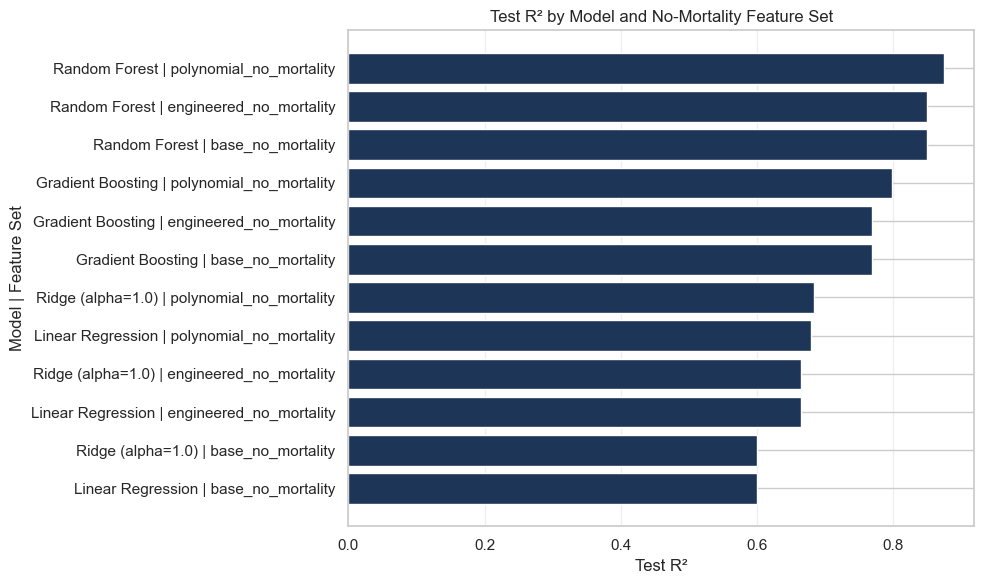

In [85]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_df = results_df.copy()
plot_df['Model+Set'] = plot_df['Model'] + ' | ' + plot_df['Feature_Set']
plot_df = plot_df.sort_values('Test_R2', ascending=True)

ax.barh(plot_df['Model+Set'], plot_df['Test_R2'], color='#1d3557')
ax.set_title('Test R² by Model and No-Mortality Feature Set')
ax.set_xlabel('Test R²')
ax.set_ylabel('Model | Feature Set')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 6) Select Best No-Mortality Model

In [86]:
best_row = results_df.iloc[0]
best_key = (best_row['Model'], best_row['Feature_Set'])
best = artifacts[best_key]

print('Best no-mortality model combination:')
print(best_row[['Model', 'Feature_Set', 'N_Features', 'Test_R2', 'Test_RMSE', 'Test_MAE']])


Best no-mortality model combination:
Model                    Random Forest
Feature_Set    polynomial_no_mortality
N_Features                          54
Test_R2                       0.875152
Test_RMSE                     2.482552
Test_MAE                      1.690643
Name: 0, dtype: object


## 7) Full-Model Baseline Comparison (Temporal Holdout)


In [87]:
full_feature_12 = [
    'alcohol_per_capita_15plus',
    'che_pct_gdp',
    'hepb3_coverage_pct',
    'pol3_coverage_pct',
    'dtp3_coverage_pct',
    'log_gdp_per_capita_2015usd',
    'overweight_adults_pct',
    'underweight_adults_pct',
    'thinness_children_adolescents_pct',
    'adult_mortality_15_60',
    'u5_mortality_rate',
    'log_infant_deaths' if 'log_infant_deaths' in full_df.columns else 'infant_deaths',
]

missing_full = [c for c in full_feature_12 if c not in full_df.columns]
if missing_full:
    raise ValueError(f'Missing required full-model features: {missing_full}')

X_train_full = train_df[full_feature_12].copy()
X_test_full = test_df[full_feature_12].copy()
y_train_full = train_df[TARGET].to_numpy()
y_test_full = test_df[TARGET].to_numpy()

# Best no-mortality scores per model
nomort_best_by_model = (
    results_df.sort_values(['Model', 'Test_R2', 'Test_RMSE'], ascending=[True, False, True])
    .groupby('Model', as_index=False)
    .first()[['Model', 'Test_R2', 'Test_RMSE']]
    .rename(columns={'Test_R2': 'NoMort_R2', 'Test_RMSE': 'NoMort_RMSE'})
)

full_rows = []
for model_name, model in build_models().items():
    pipe_full = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', model),
    ])
    pipe_full.fit(X_train_full, y_train_full)
    full_pred = pipe_full.predict(X_test_full)
    full_rows.append({
        'Model': model_name,
        'Full_R2': r2_score(y_test_full, full_pred),
        'Full_RMSE': float(np.sqrt(mean_squared_error(y_test_full, full_pred))),
    })

full_scores_df = pd.DataFrame(full_rows)
comparison_df = full_scores_df.merge(nomort_best_by_model, on='Model', how='inner')
comparison_df['R2_Drop'] = comparison_df['Full_R2'] - comparison_df['NoMort_R2']
comparison_df['RMSE_Increase'] = comparison_df['NoMort_RMSE'] - comparison_df['Full_RMSE']
comparison_df = comparison_df[['Model', 'Full_R2', 'NoMort_R2', 'R2_Drop', 'Full_RMSE', 'NoMort_RMSE', 'RMSE_Increase']]
comparison_df = comparison_df.sort_values('Full_R2', ascending=False).reset_index(drop=True)

comparison_styled = comparison_df.style.format({
    'Full_R2': '{:.4f}',
    'NoMort_R2': '{:.4f}',
    'R2_Drop': '{:.4f}',
    'Full_RMSE': '{:.4f}',
    'NoMort_RMSE': '{:.4f}',
    'RMSE_Increase': '{:.4f}',
})
comparison_styled


,Model,Full_R2,NoMort_R2,R2_Drop,Full_RMSE,NoMort_RMSE,RMSE_Increase
0,Random Forest,0.9881,0.8752,0.1130,0.7664,2.4826,1.7162
1,Gradient Boosting,0.9836,0.7979,0.1857,0.9004,3.1585,2.2581
2,Linear Regression,0.9699,0.6793,0.2906,1.2186,3.9786,2.7600
3,Ridge (alpha=1.0),0.9699,0.6832,0.2867,1.2187,3.9545,2.7358


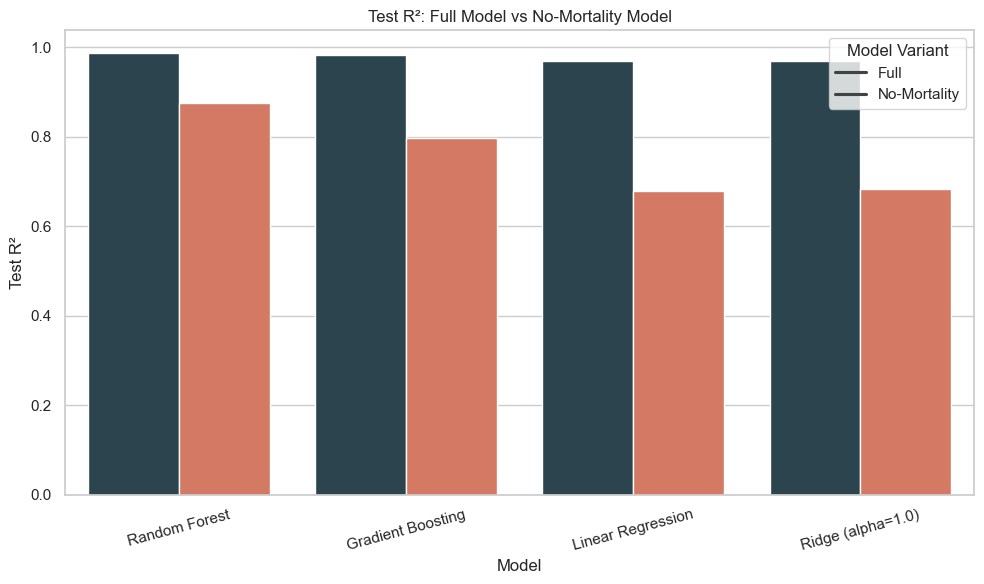

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_full_vs_nomort_comparison.png


In [88]:
plot_comp = comparison_df.melt(
    id_vars='Model',
    value_vars=['Full_R2', 'NoMort_R2'],
    var_name='Variant',
    value_name='Test_R2',
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=plot_comp,
    x='Model',
    y='Test_R2',
    hue='Variant',
    palette={'Full_R2': '#264653', 'NoMort_R2': '#e76f51'},
    ax=ax,
)
ax.set_title('Test R²: Full Model vs No-Mortality Model')
ax.set_xlabel('Model')
ax.set_ylabel('Test R²')
ax.legend(title='Model Variant', labels=['Full', 'No-Mortality'])
ax.tick_params(axis='x', rotation=15)
plt.tight_layout()
fig_path_comp = IMAGES_DIR / 'no_mort_full_vs_nomort_comparison.png'
fig.savefig(fig_path_comp, dpi=180)
plt.show()
print('Saved:', fig_path_comp)


## 8) Predicted vs Actual Scatter (Best No-Mortality Model)


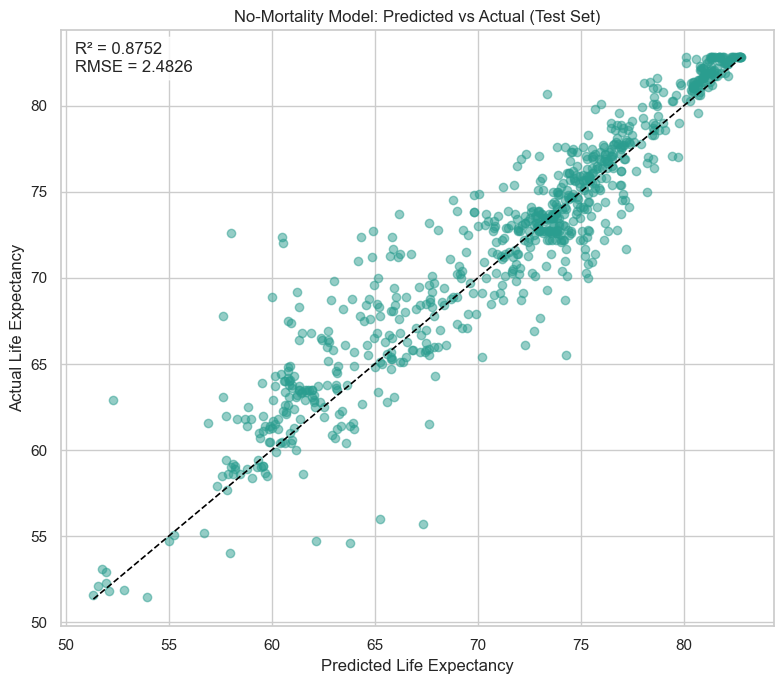

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_pred_vs_actual.png


In [89]:
best_test_pred = best['pipeline'].predict(best['X_test_raw'])
best_test_actual = best['y_test']
best_test_rmse = float(np.sqrt(mean_squared_error(best_test_actual, best_test_pred)))
best_test_r2 = r2_score(best_test_actual, best_test_pred)

plot_df_scatter = test_df.loc[best['X_test_raw'].index, [COUNTRY_COL, YEAR_COL]].copy()
plot_df_scatter['actual'] = best_test_actual
plot_df_scatter['predicted'] = best_test_pred

fig, ax = plt.subplots(figsize=(8, 7))
if REGION_COL is not None and REGION_COL in test_df.columns:
    plot_df_scatter[REGION_COL] = test_df.loc[best['X_test_raw'].index, REGION_COL].astype(str)
    sns.scatterplot(
        data=plot_df_scatter,
        x='predicted',
        y='actual',
        hue=REGION_COL,
        alpha=0.65,
        ax=ax,
    )
else:
    ax.scatter(plot_df_scatter['predicted'], plot_df_scatter['actual'], color='#2a9d8f', alpha=0.5)

mn = min(plot_df_scatter['predicted'].min(), plot_df_scatter['actual'].min())
mx = max(plot_df_scatter['predicted'].max(), plot_df_scatter['actual'].max())
ax.plot([mn, mx], [mn, mx], linestyle='--', color='black', linewidth=1.2)
ax.set_title('No-Mortality Model: Predicted vs Actual (Test Set)')
ax.set_xlabel('Predicted Life Expectancy')
ax.set_ylabel('Actual Life Expectancy')
ax.text(
    0.02,
    0.98,
    f'R² = {best_test_r2:.4f}\nRMSE = {best_test_rmse:.4f}',
    transform=ax.transAxes,
    va='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
)
plt.tight_layout()
fig_path_scatter = IMAGES_DIR / 'no_mort_pred_vs_actual.png'
fig.savefig(fig_path_scatter, dpi=180)
plt.show()
print('Saved:', fig_path_scatter)


## 9) Residual Diagnostics


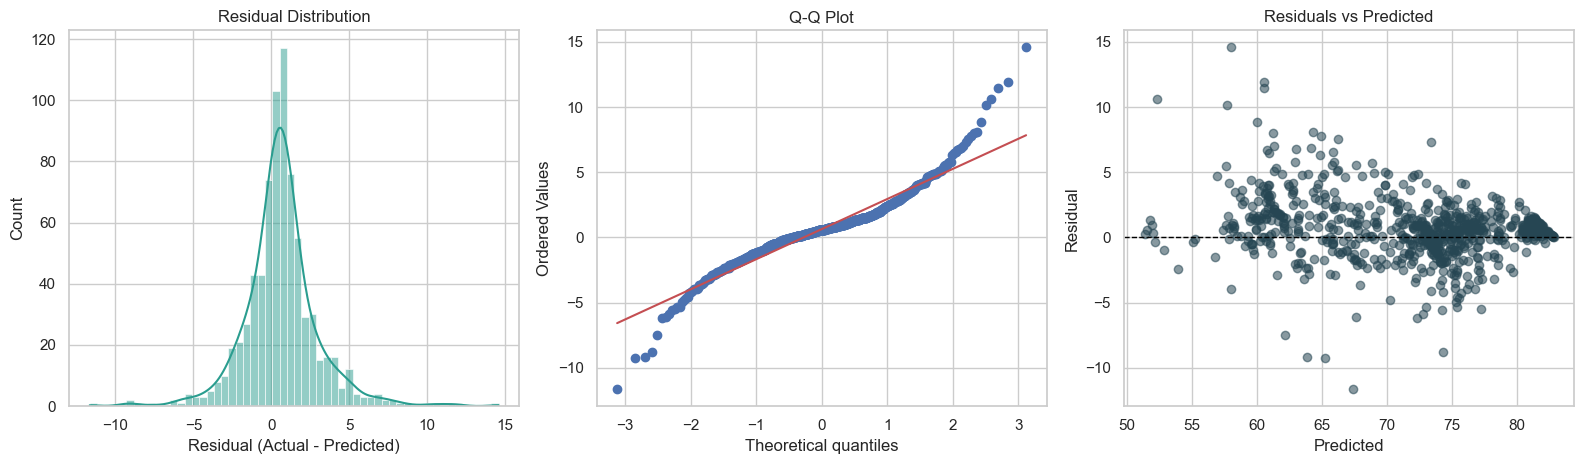

Residual mean   : 0.627919
Residual median : 0.573195
Residual std    : 2.403394
Shapiro-Wilk stat: 0.922034
Shapiro-Wilk p   : 0.0
Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_residual_diagnostics.png


In [90]:
residuals = best_test_actual - best_test_pred

fig, axes = plt.subplots(1, 3, figsize=(16, 4.8))

sns.histplot(residuals, kde=True, color='#2a9d8f', ax=axes[0])
axes[0].set_title('Residual Distribution')
axes[0].set_xlabel('Residual (Actual - Predicted)')

stats.probplot(residuals, dist='norm', plot=axes[1])
axes[1].set_title('Q-Q Plot')

axes[2].scatter(best_test_pred, residuals, color='#264653', alpha=0.55)
axes[2].axhline(0, color='black', linestyle='--', linewidth=1)
axes[2].set_title('Residuals vs Predicted')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Residual')

plt.tight_layout()
fig_path_resid = IMAGES_DIR / 'no_mort_residual_diagnostics.png'
fig.savefig(fig_path_resid, dpi=180)
plt.show()

shapiro_stat, shapiro_p = stats.shapiro(residuals)
print('Residual mean   :', round(float(np.mean(residuals)), 6))
print('Residual median :', round(float(np.median(residuals)), 6))
print('Residual std    :', round(float(np.std(residuals, ddof=1)), 6))
print('Shapiro-Wilk stat:', round(float(shapiro_stat), 6))
print('Shapiro-Wilk p   :', round(float(shapiro_p), 6))
print('Saved:', fig_path_resid)


## 10) Country-Level Error Analysis


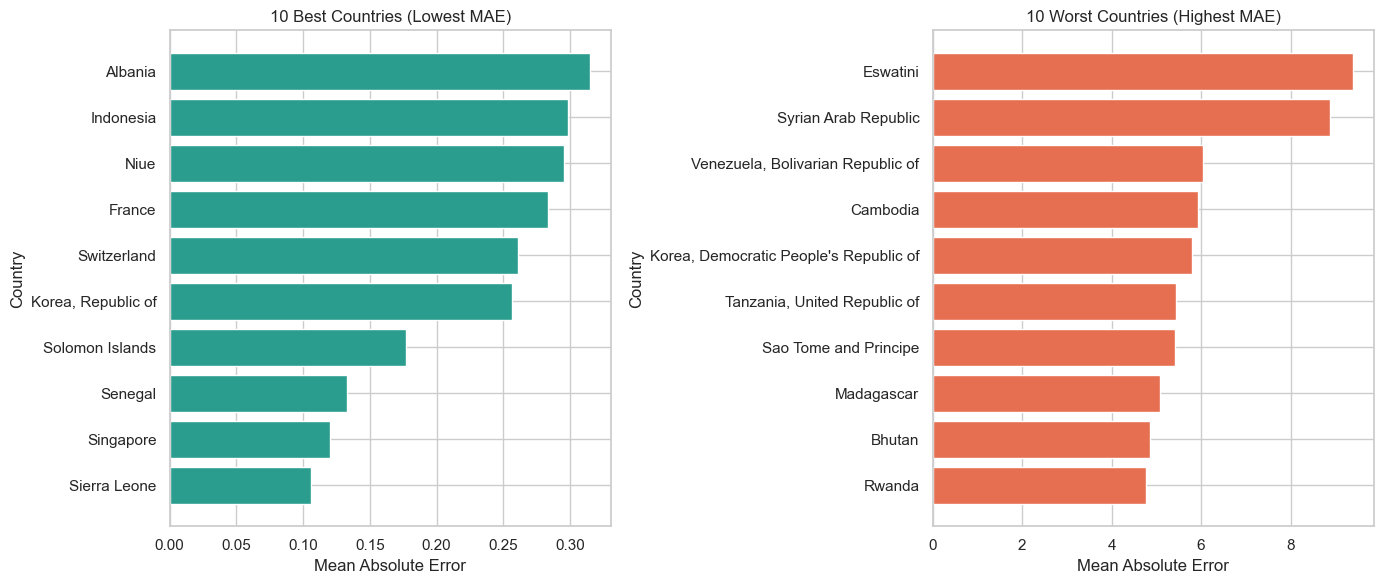

                               Country  MAE_2018_2021
                          Sierra Leone       0.105750
                             Singapore       0.120000
                               Senegal       0.133000
                       Solomon Islands       0.177000
                    Korea, Republic of       0.256500
                           Switzerland       0.260750
                                France       0.283250
                                  Niue       0.295750
                             Indonesia       0.298790
                               Albania       0.315000
                               Ireland       0.347500
      Saint Vincent and the Grenadines       0.350250
                                 Tonga       0.366500
                                Israel       0.374000
                               Morocco       0.375000
                            Montenegro       0.391750
                                 Japan       0.407500
                           N

In [91]:
country_eval_df = test_df.loc[best['X_test_raw'].index, [COUNTRY_COL, YEAR_COL]].copy()
country_eval_df['actual'] = best_test_actual
country_eval_df['predicted'] = best_test_pred
country_eval_df['abs_error'] = np.abs(country_eval_df['actual'] - country_eval_df['predicted'])

country_mae_df = (
    country_eval_df.groupby(COUNTRY_COL, as_index=False)['abs_error']
    .mean()
    .rename(columns={'abs_error': 'MAE_2018_2021'})
    .sort_values('MAE_2018_2021', ascending=True)
    .reset_index(drop=True)
)

best_10 = country_mae_df.head(10).sort_values('MAE_2018_2021', ascending=True)
worst_10 = country_mae_df.tail(10).sort_values('MAE_2018_2021', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False)
axes[0].barh(best_10[COUNTRY_COL], best_10['MAE_2018_2021'], color='#2a9d8f')
axes[0].set_title('10 Best Countries (Lowest MAE)')
axes[0].set_xlabel('Mean Absolute Error')
axes[0].set_ylabel(COUNTRY_COL)

axes[1].barh(worst_10[COUNTRY_COL], worst_10['MAE_2018_2021'], color='#e76f51')
axes[1].set_title('10 Worst Countries (Highest MAE)')
axes[1].set_xlabel('Mean Absolute Error')
axes[1].set_ylabel(COUNTRY_COL)

plt.tight_layout()
fig_path_country = IMAGES_DIR / 'no_mort_country_errors.png'
fig.savefig(fig_path_country, dpi=180)
plt.show()

print(country_mae_df.to_string(index=False))
print('Saved:', fig_path_country)


## 11) Year-by-Year Test Performance


 Year       R2     RMSE   N
 2018 0.953510 1.550781 192
 2019 0.909388 2.124682 192
 2020 0.836882 2.769306 192
 2021 0.789659 3.172382 192


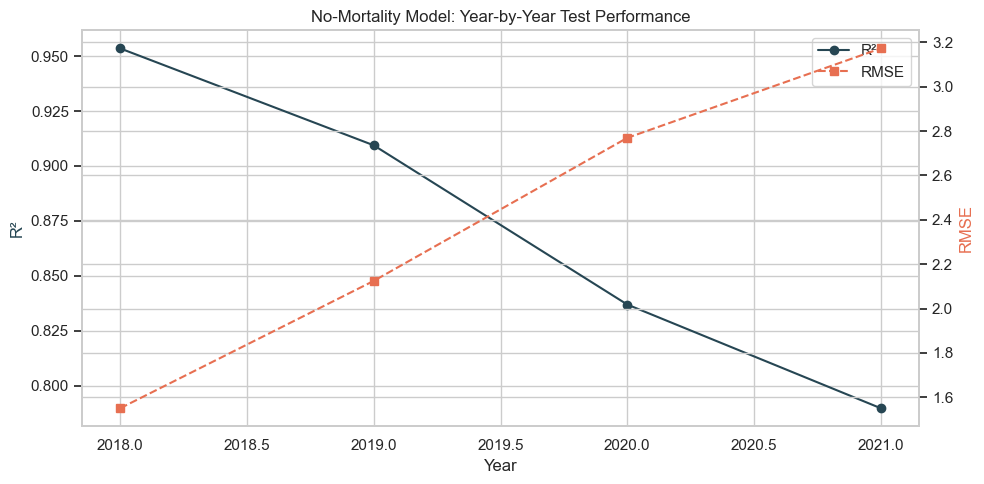

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_yearly_performance.png


In [92]:
year_eval_df = country_eval_df[[YEAR_COL, 'actual', 'predicted']].copy()
yearly_rows = []
for yr, grp in year_eval_df.groupby(YEAR_COL):
    if len(grp) < 2:
        yr_r2 = np.nan
    else:
        yr_r2 = r2_score(grp['actual'], grp['predicted'])
    yr_rmse = float(np.sqrt(mean_squared_error(grp['actual'], grp['predicted'])))
    yearly_rows.append({'Year': int(yr), 'R2': yr_r2, 'RMSE': yr_rmse, 'N': len(grp)})

yearly_perf_df = pd.DataFrame(yearly_rows).sort_values('Year').reset_index(drop=True)
print(yearly_perf_df.to_string(index=False))

fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(yearly_perf_df['Year'], yearly_perf_df['R2'], marker='o', color='#264653', label='R²')
ax2.plot(yearly_perf_df['Year'], yearly_perf_df['RMSE'], marker='s', linestyle='--', color='#e76f51', label='RMSE')

ax1.set_xlabel('Year')
ax1.set_ylabel('R²', color='#264653')
ax2.set_ylabel('RMSE', color='#e76f51')
ax1.set_title('No-Mortality Model: Year-by-Year Test Performance')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.tight_layout()
fig_path_yearly = IMAGES_DIR / 'no_mort_yearly_performance.png'
fig.savefig(fig_path_yearly, dpi=180)
plt.show()
print('Saved:', fig_path_yearly)


## 12) Feature Group Ablation (No-Mortality)


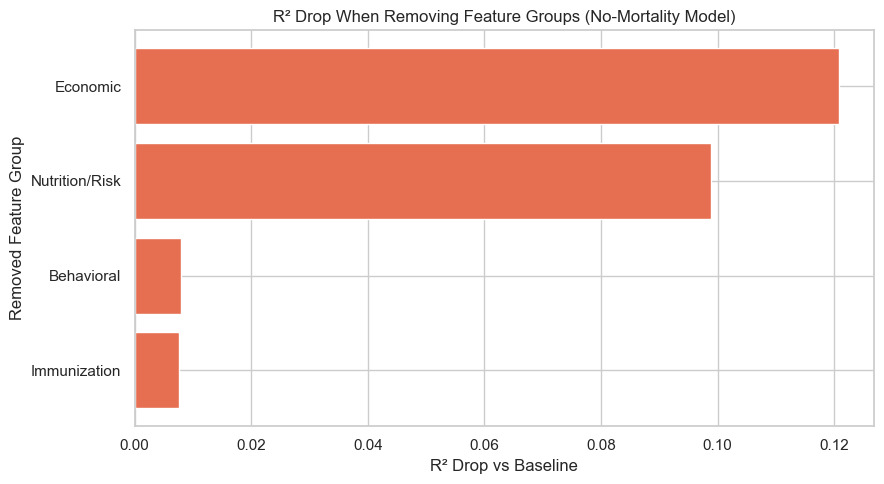

           Scenario  Removed_Group  Test_R2  R2_Drop_vs_Baseline
      Drop Economic       Economic 0.726089             0.120771
Drop Nutrition/Risk Nutrition/Risk 0.748047             0.098812
    Drop Behavioral     Behavioral 0.838859             0.008000
  Drop Immunization   Immunization 0.839162             0.007697
   Baseline (All 9)           None 0.846859             0.000000
Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_feature_ablation.png


In [93]:
ablation_features = [
    'log_gdp_per_capita_2015usd',
    'che_pct_gdp',
    'hepb3_coverage_pct',
    'pol3_coverage_pct',
    'dtp3_coverage_pct',
    'overweight_adults_pct',
    'underweight_adults_pct',
    'thinness_children_adolescents_pct',
    'alcohol_per_capita_15plus',
]

missing_ablation = [c for c in ablation_features if c not in full_df.columns]
if missing_ablation:
    raise ValueError(f'Missing required ablation features: {missing_ablation}')

feature_groups = {
    'Economic': ['log_gdp_per_capita_2015usd', 'che_pct_gdp'],
    'Immunization': ['hepb3_coverage_pct', 'pol3_coverage_pct', 'dtp3_coverage_pct'],
    'Nutrition/Risk': ['overweight_adults_pct', 'underweight_adults_pct', 'thinness_children_adolescents_pct'],
    'Behavioral': ['alcohol_per_capita_15plus'],
}

best_model_name = best_row['Model']
best_model = build_models()[best_model_name]


def run_ablation(feature_list):
    Xtr = train_df[feature_list].copy()
    Xte = test_df[feature_list].copy()
    ytr = train_df[TARGET].to_numpy()
    yte = test_df[TARGET].to_numpy()

    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', best_model),
    ])
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xte)
    return r2_score(yte, pred)

baseline_r2 = run_ablation(ablation_features)
ablation_rows = [{'Scenario': 'Baseline (All 9)', 'Removed_Group': 'None', 'Test_R2': baseline_r2}]

for group_name, drop_cols in feature_groups.items():
    keep_cols = [c for c in ablation_features if c not in drop_cols]
    r2_val = run_ablation(keep_cols)
    ablation_rows.append({
        'Scenario': f'Drop {group_name}',
        'Removed_Group': group_name,
        'Test_R2': r2_val,
    })

ablation_df = pd.DataFrame(ablation_rows)
ablation_df['R2_Drop_vs_Baseline'] = baseline_r2 - ablation_df['Test_R2']
ablation_df = ablation_df.sort_values('R2_Drop_vs_Baseline', ascending=False).reset_index(drop=True)

plot_ablation = ablation_df[ablation_df['Removed_Group'] != 'None'].sort_values('R2_Drop_vs_Baseline', ascending=True)
fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(plot_ablation['Removed_Group'], plot_ablation['R2_Drop_vs_Baseline'], color='#e76f51')
ax.set_title('R² Drop When Removing Feature Groups (No-Mortality Model)')
ax.set_xlabel('R² Drop vs Baseline')
ax.set_ylabel('Removed Feature Group')
plt.tight_layout()
fig_path_ablation = IMAGES_DIR / 'no_mort_feature_ablation.png'
fig.savefig(fig_path_ablation, dpi=180)
plt.show()

print(ablation_df.to_string(index=False))
print('Saved:', fig_path_ablation)


## 13) Correlation Heatmap (Non-Mortality Predictors)


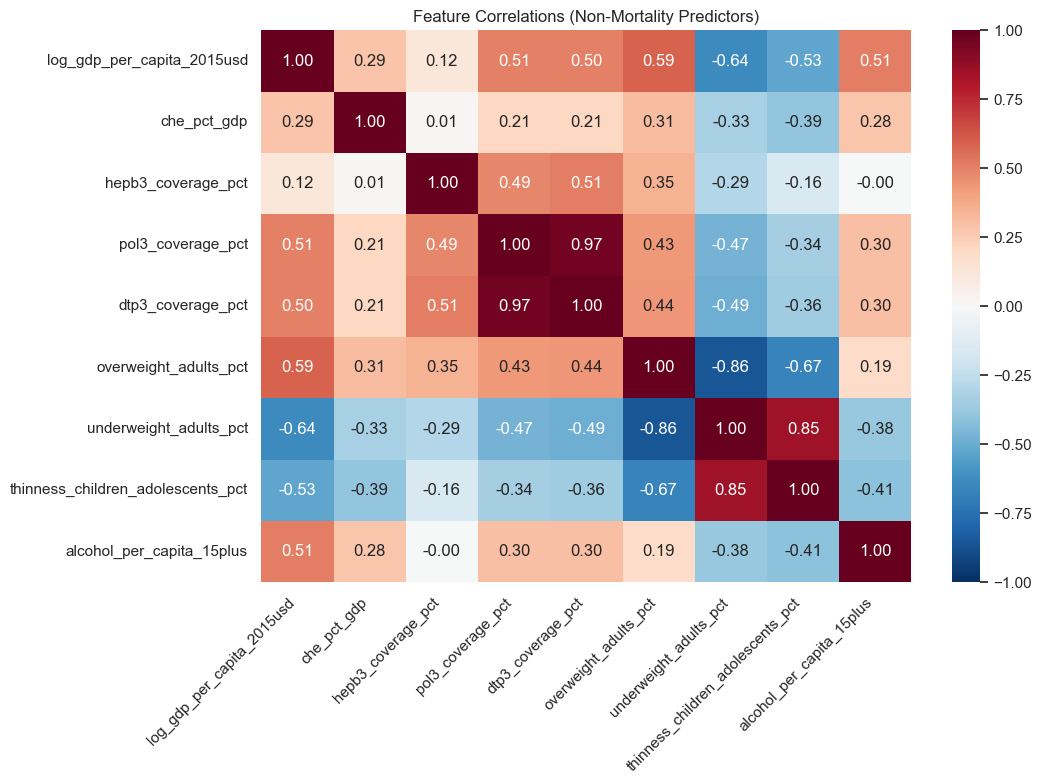

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_correlation_heatmap.png


In [94]:
corr_df = full_df[ablation_features].corr(method='pearson')

fig, ax = plt.subplots(figsize=(11, 8))
sns.heatmap(
    corr_df,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
)
ax.set_title('Feature Correlations (Non-Mortality Predictors)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
fig_path_corr = IMAGES_DIR / 'no_mort_correlation_heatmap.png'
fig.savefig(fig_path_corr, dpi=180)
plt.show()
print('Saved:', fig_path_corr)


## 14) Export Figures and Tables


In [95]:
figure_paths = [
    fig_path_comp,
    fig_path_scatter,
    fig_path_resid,
    fig_path_country,
    fig_path_yearly,
    fig_path_ablation,
    fig_path_corr,
]

print('Figure files:')
for p in figure_paths:
    print(f' - {p} | exists={p.exists()}')

comparison_csv = EXPORT_DIR / 'comparison_table_no_mort_vs_full.csv'
country_csv = EXPORT_DIR / 'country_mae_table_no_mort.csv'
ablation_csv = EXPORT_DIR / 'ablation_results_no_mort.csv'

comparison_df.to_csv(comparison_csv, index=False)
country_mae_df.to_csv(country_csv, index=False)
ablation_df.to_csv(ablation_csv, index=False)

print('\nExported tables:')
print(' -', comparison_csv)
print(' -', country_csv)
print(' -', ablation_csv)


Figure files:
 - /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_full_vs_nomort_comparison.png | exists=True
 - /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_pred_vs_actual.png | exists=True
 - /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_residual_diagnostics.png | exists=True
 - /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_country_errors.png | exists=True
 - /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_yearly_performance.png | exists=True
 - /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_feature_ablation.png | exists=True
 - /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_correlation_heatmap.png | exists=True

Exported tables:
 - /Users/bikki/Documents/Projects_Spring_2026/STATS201/cleaner_exports/comparison_table_no_mort_vs_full.csv
 - /Users/bikki/Documents/Projects_Spring_2026/STATS201/cleaner_exports/country_mae_table_no_mort.csv
 

## 7) Variable Weightage (Random Forest + Permutation Importance)

In [96]:
# Use permutation importance on test set to get robust feature weightage
pi = permutation_importance(
    estimator=best['pipeline'],
    X=best['X_test_raw'],
    y=best['y_test'],
    n_repeats=20,
    random_state=RANDOM_STATE,
    scoring='r2',
)

imp_df = pd.DataFrame({
    'Feature': best['feature_names'],
    'Importance': pi.importances_mean,
})
imp_df = imp_df.sort_values('Importance', ascending=False).reset_index(drop=True)
imp_df['Weight_%'] = 100 * imp_df['Importance'] / imp_df['Importance'].sum()

imp_df.head(15)


,Feature,Importance,Weight_%
0,che_pct_gdp gdp_per_capita_2015usd,0.337716,36.498446
1,pol3_coverage_pct gdp_per_capita_2015usd,0.134160,14.499258
2,dtp3_coverage_pct gdp_per_capita_2015usd,0.052649,5.689989
3,alcohol_per_capita_15plus thinness_children_ad...,0.045715,4.940650
4,che_pct_gdp underweight_adults_pct,0.039039,4.219148
5,alcohol_per_capita_15plus underweight_adults_pct,0.038396,4.149633
6,overweight_adults_pct underweight_adults_pct,0.032001,3.458514
7,dtp3_coverage_pct overweight_adults_pct,0.029686,3.208322
8,che_pct_gdp overweight_adults_pct,0.025688,2.776247
9,dtp3_coverage_pct thinness_children_adolescent...,0.023256,2.513418


## 8) Graph 2: Top Variable Weightage (No-Mortality Model)

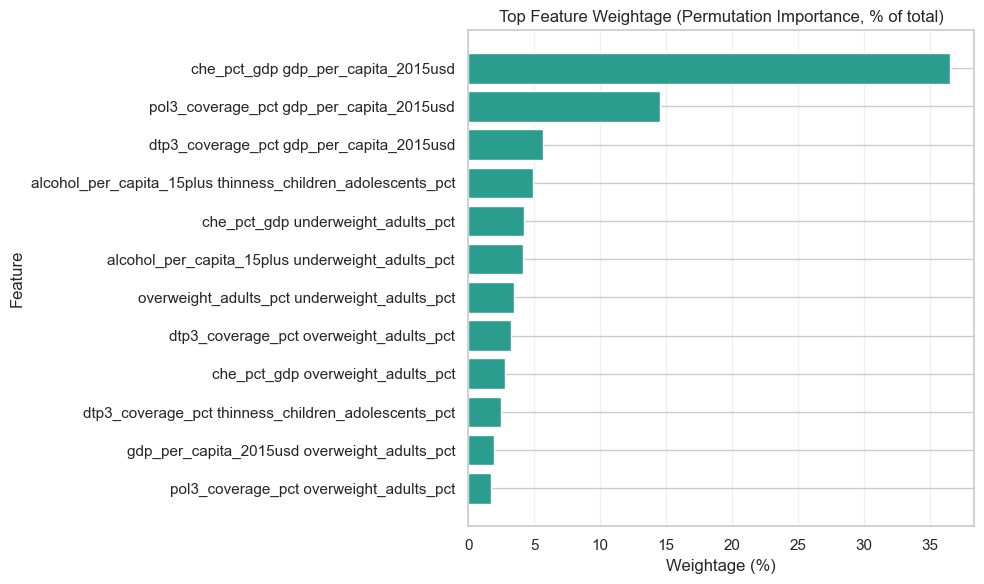

In [97]:
top_n = min(12, len(imp_df))
plot_imp = imp_df.head(top_n).sort_values('Weight_%', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(plot_imp['Feature'], plot_imp['Weight_%'], color='#2a9d8f')
ax.set_title('Top Feature Weightage (Permutation Importance, % of total)')
ax.set_xlabel('Weightage (%)')
ax.set_ylabel('Feature')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 9) Cross-Check Weightage with Standardized Linear Coefficients

In [98]:
lin_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0)),
])

# Use engineered no-mortality set for interpretability
X_train_raw, X_test_raw, y_train, y_test, feat_names = make_xy(train_df, test_df, 'engineered_no_mortality')
lin_pipe.fit(X_train_raw, y_train)

coef = lin_pipe.named_steps['model'].coef_
coef_df = pd.DataFrame({
    'Feature': feat_names,
    'Std_Coefficient': coef,
    'Abs_Std_Coefficient': np.abs(coef),
}).sort_values('Abs_Std_Coefficient', ascending=False)

coef_df['Weight_%'] = 100 * coef_df['Abs_Std_Coefficient'] / coef_df['Abs_Std_Coefficient'].sum()
print('Ridge (engineered_no_mortality) Test R²:', round(r2_score(y_test, lin_pipe.predict(X_test_raw)), 4))
coef_df


Ridge (engineered_no_mortality) Test R²: 0.6645


,Feature,Std_Coefficient,Abs_Std_Coefficient,Weight_%
5,log_gdp_per_capita_2015usd,5.053855,5.053855,47.500336
3,pol3_coverage_pct,1.663621,1.663621,15.636095
7,underweight_adults_pct,-1.058425,1.058425,9.947958
8,thinness_children_adolescents_pct,0.772218,0.772218,7.257951
6,overweight_adults_pct,0.762201,0.762201,7.163802
4,dtp3_coverage_pct,0.586362,0.586362,5.511115
0,alcohol_per_capita_15plus,-0.399745,0.399745,3.757133
1,che_pct_gdp,0.280520,0.280520,2.636564
2,hepb3_coverage_pct,0.062672,0.062672,0.589045


## 10) Graph 3: Linear Model Weightage (No-Mortality Features)

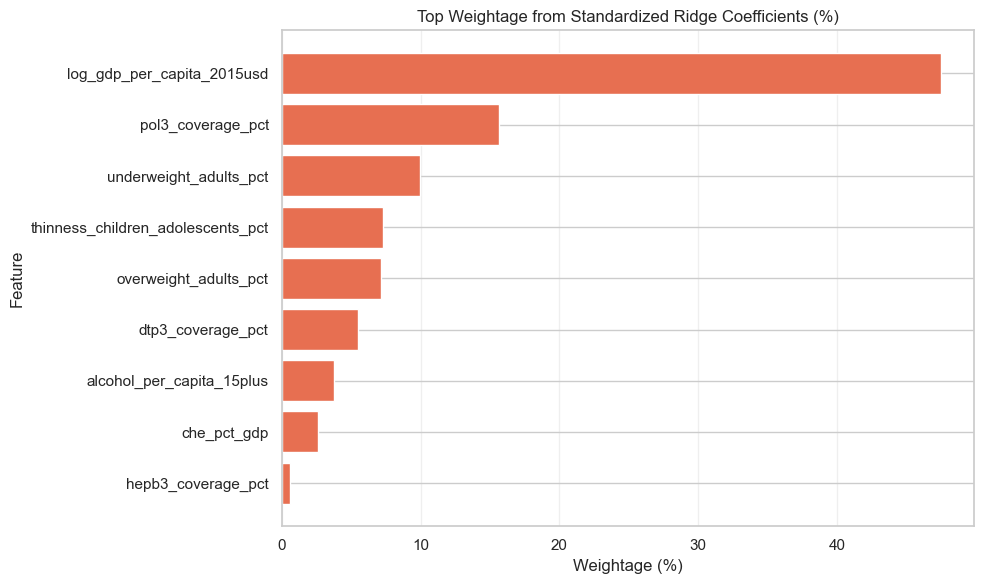

In [99]:
plot_coef = coef_df.head(10).sort_values('Weight_%', ascending=True)
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(plot_coef['Feature'], plot_coef['Weight_%'], color='#e76f51')
ax.set_title('Top Weightage from Standardized Ridge Coefficients (%)')
ax.set_xlabel('Weightage (%)')
ax.set_ylabel('Feature')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 11) Concise Interpretation

- All model runs in this notebook exclude mortality/death variables (`adult_mortality_15_60`, `u5_mortality_rate`, `infant_deaths`, `log_infant_deaths`).
- The model-comparison table and Graph 1 show how much predictive performance remains from non-mortality indicators.
- The weightage tables and Graphs 2-3 identify the strongest non-mortality drivers.
- Report both permutation-based and linear-coefficient-based weightage to avoid relying on one interpretation method.


## 12) Final Summary

This no-mortality analysis re-estimates life-expectancy models after excluding direct mortality/death indicators (`adult_mortality_15_60`, `u5_mortality_rate`, `infant_deaths`, `log_infant_deaths`). Across the tested pipelines, predictive performance remains meaningful, showing that non-mortality factors still contain substantial signal.

The strongest remaining predictors are primarily socioeconomic and health-system coverage/financing variables (as shown in the permutation-importance and standardized-coefficient weightage tables). This indicates that differences in economic conditions, immunization coverage, health spending structure, and nutrition-risk profile explain a sizable share of life-expectancy variation even without mortality-based inputs.

Interpretation should remain associative rather than causal: these feature weights describe model dependence in this dataset and temporal split, not guaranteed policy effect sizes. Still, the results provide a clearer, less tautological view of which non-mortality indicators are most informative for prediction.


## 15) No-Mortality Projections (2022–2025)


Projection rows: 1728 | Countries: 192
Best feature set used for projection: polynomial_no_mortality

Top 10 projected life expectancy in 2025:
           Country  pred_life_expectancy
Korea, Republic of                82.595
       Switzerland                82.190
            Israel                82.039
            France                81.858
         Singapore                81.841
             Japan                81.637
            Norway                81.591
            Cyprus                81.476
           Finland                81.424
           Ireland                81.026

Bottom 10 projected life expectancy in 2025:
                              Country  pred_life_expectancy
    Venezuela, Bolivarian Republic of              56.20853
                        Guinea-Bissau              56.06061
Congo, The Democratic Republic of the              55.96123
                               Zambia              55.60276
                                 Togo              55.53775

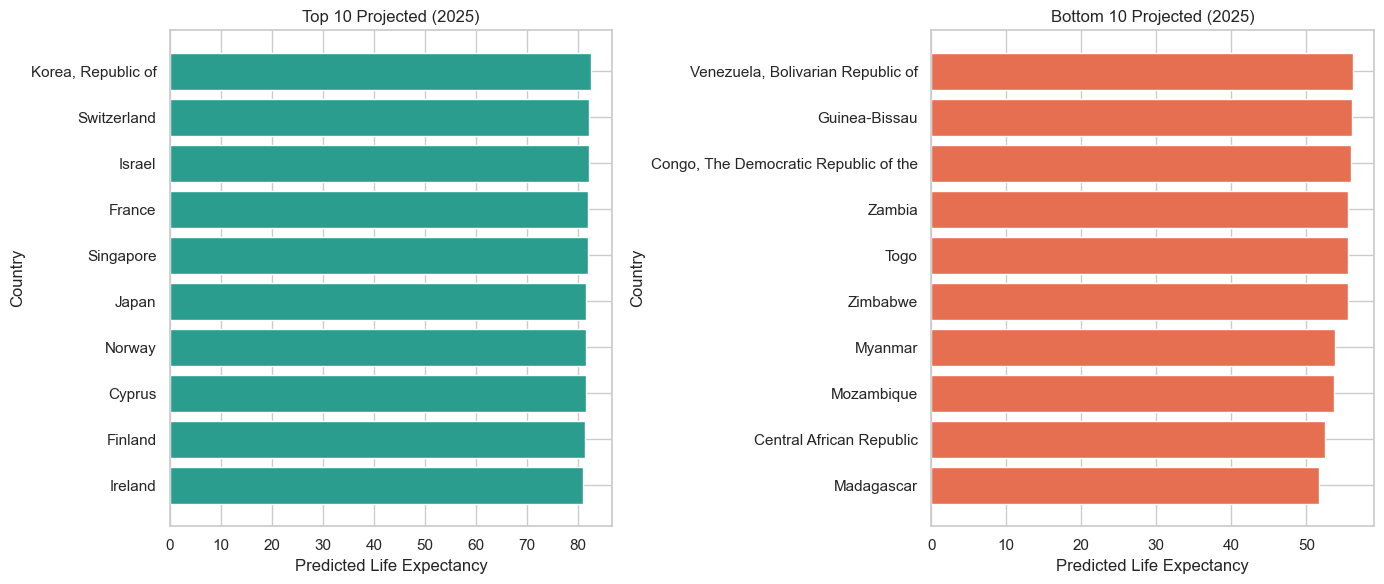

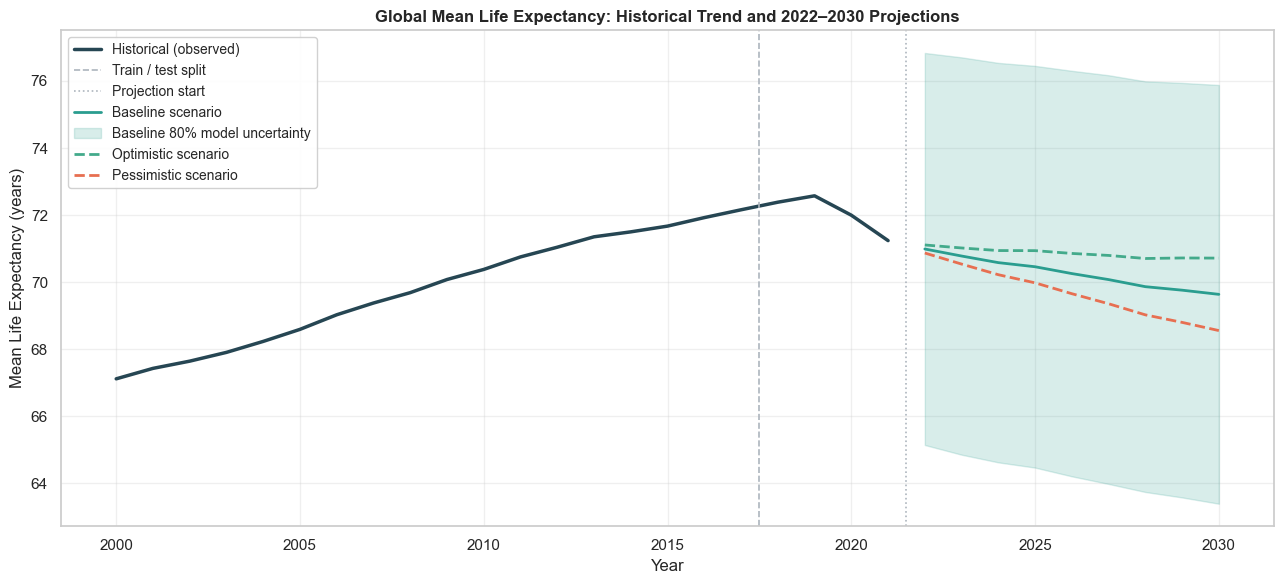

Selected countries for projection panel: ['Japan', 'Germany', 'Brazil', 'India', 'Nigeria', 'United States']


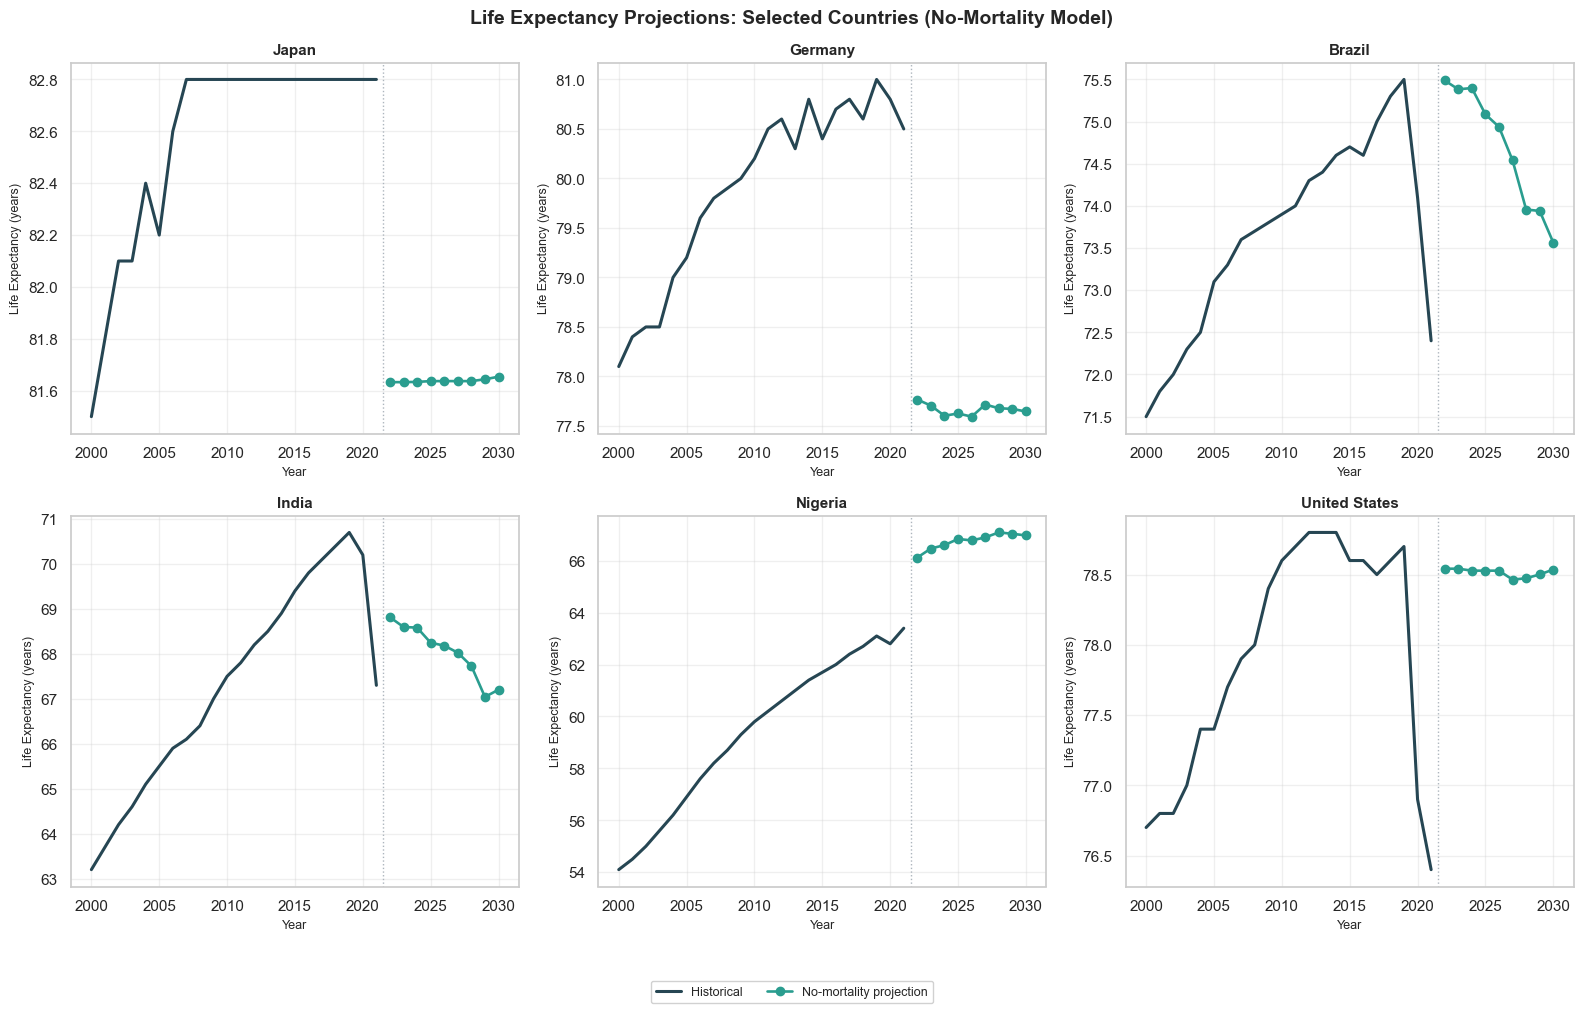

Saved figure: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_projection_2025_top_bottom.png
Saved figure: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_projection_global_trend.png
Saved figure: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/no_mort_projection_country_examples.png
Saved table : /Users/bikki/Documents/Projects_Spring_2026/STATS201/cleaner_exports/no_mortality_projections_2022_2030.csv
Saved table : /Users/bikki/Documents/Projects_Spring_2026/STATS201/cleaner_exports/no_mortality_projection_2025_ranked.csv


In [100]:
# Country-level forward projection of non-mortality features, then life expectancy prediction
projection_years = list(range(2022, 2031))
raw_projection_cols = sorted(set(no_mortality_base + no_mortality_engineered))

missing_proj = [c for c in raw_projection_cols if c not in full_df.columns]
if missing_proj:
    raise ValueError(f'Missing projection features: {missing_proj}')

hist = full_df[[COUNTRY_COL, YEAR_COL] + raw_projection_cols].copy()
hist[YEAR_COL] = pd.to_numeric(hist[YEAR_COL], errors='coerce')
hist = hist.dropna(subset=[COUNTRY_COL, YEAR_COL]).sort_values([COUNTRY_COL, YEAR_COL])


def extrapolate_feature(series_df, feature, target_year):
    tmp = series_df[[YEAR_COL, feature]].dropna().sort_values(YEAR_COL)
    if tmp.empty:
        return np.nan
    tmp = tmp.tail(5)
    if len(tmp) >= 2:
        x = tmp[YEAR_COL].to_numpy(dtype=float)
        y = tmp[feature].to_numpy(dtype=float)
        slope, intercept = np.polyfit(x, y, 1)
        return float(intercept + slope * target_year)
    return float(tmp[feature].iloc[-1])


proj_rows = []
for country, g in hist.groupby(COUNTRY_COL):
    for y in projection_years:
        row = {COUNTRY_COL: country, YEAR_COL: y}
        for f in raw_projection_cols:
            row[f] = extrapolate_feature(g, f, y)
        proj_rows.append(row)

proj_df = pd.DataFrame(proj_rows)

pct_like = [
    'che_pct_gdp', 'hepb3_coverage_pct', 'pol3_coverage_pct', 'dtp3_coverage_pct',
    'overweight_adults_pct', 'underweight_adults_pct', 'thinness_children_adolescents_pct',
]
for c in pct_like:
    if c in proj_df.columns:
        proj_df[c] = proj_df[c].clip(lower=0, upper=100)

if 'alcohol_per_capita_15plus' in proj_df.columns:
    proj_df['alcohol_per_capita_15plus'] = proj_df['alcohol_per_capita_15plus'].clip(lower=0)
if 'gdp_per_capita_2015usd' in proj_df.columns:
    proj_df['gdp_per_capita_2015usd'] = proj_df['gdp_per_capita_2015usd'].clip(lower=0)

# Build projection design matrix to match the selected best no-mortality feature set
best_feature_set = best_row['Feature_Set'] if 'best_row' in globals() else None

if best_feature_set == 'base_no_mortality':
    proj_X = proj_df[no_mortality_base].copy()
elif best_feature_set == 'engineered_no_mortality':
    proj_X = proj_df[no_mortality_engineered].copy()
elif best_feature_set == 'polynomial_no_mortality':
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly.fit(train_df[no_mortality_base].copy())
    proj_X = pd.DataFrame(
        poly.transform(proj_df[no_mortality_base].copy()),
        columns=poly.get_feature_names_out(no_mortality_base),
        index=proj_df.index,
    )
else:
    # Fallback: infer polynomial by feature-name pattern, else direct column selection
    if any(('^' in f) or (' ' in f) for f in best['feature_names']):
        poly = PolynomialFeatures(degree=2, include_bias=False)
        poly.fit(train_df[no_mortality_base].copy())
        proj_X = pd.DataFrame(
            poly.transform(proj_df[no_mortality_base].copy()),
            columns=poly.get_feature_names_out(no_mortality_base),
            index=proj_df.index,
        )
    else:
        proj_X = proj_df.copy()

missing_for_best = [f for f in best['feature_names'] if f not in proj_X.columns]
if missing_for_best:
    raise ValueError(f'Projection design matrix is missing features for best model: {missing_for_best[:10]} ...')

proj_X = proj_X[best['feature_names']].copy()
proj_df['pred_life_expectancy'] = best['pipeline'].predict(proj_X)

projection_summary_2025 = (
    proj_df[proj_df[YEAR_COL] == 2025][[COUNTRY_COL, 'pred_life_expectancy']]
    .sort_values('pred_life_expectancy', ascending=False)
    .reset_index(drop=True)
)

print('Projection rows:', len(proj_df), '| Countries:', proj_df[COUNTRY_COL].nunique())
print('Best feature set used for projection:', best_feature_set)
print('')
print('Top 10 projected life expectancy in 2025:')
print(projection_summary_2025.head(10).to_string(index=False))
print('')
print('Bottom 10 projected life expectancy in 2025:')
print(projection_summary_2025.tail(10).to_string(index=False))

plot_top = projection_summary_2025.head(10).sort_values('pred_life_expectancy', ascending=True)
plot_bot = projection_summary_2025.tail(10).sort_values('pred_life_expectancy', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].barh(plot_top[COUNTRY_COL], plot_top['pred_life_expectancy'], color='#2a9d8f')
axes[0].set_title('Top 10 Projected (2025)')
axes[0].set_xlabel('Predicted Life Expectancy')
axes[0].set_ylabel(COUNTRY_COL)

axes[1].barh(plot_bot[COUNTRY_COL], plot_bot['pred_life_expectancy'], color='#e76f51')
axes[1].set_title('Bottom 10 Projected (2025)')
axes[1].set_xlabel('Predicted Life Expectancy')
axes[1].set_ylabel(COUNTRY_COL)

plt.tight_layout()
fig_path_proj = IMAGES_DIR / 'no_mort_projection_2025_top_bottom.png'
fig.savefig(fig_path_proj, dpi=180)
plt.show()

# Global mean trend chart with scenario-style lines (to match projection notebook style)
hist_mean = (
    full_df.groupby(YEAR_COL)[TARGET]
    .mean()
    .reset_index(name='mean_le')
    .sort_values(YEAR_COL)
)
baseline_mean = (
    proj_df.groupby(YEAR_COL)['pred_life_expectancy']
    .mean()
    .reset_index(name='mean_le')
    .sort_values(YEAR_COL)
)
baseline_std = (
    proj_df.groupby(YEAR_COL)['pred_life_expectancy']
    .std()
    .reset_index(name='std_le')
    .sort_values(YEAR_COL)
)
trend_df = baseline_mean.merge(baseline_std, on=YEAR_COL, how='left')
trend_df['std_le'] = trend_df['std_le'].fillna(0.0)
trend_df['years_ahead'] = trend_df[YEAR_COL] - 2021

# Scenario deltas (visual comparison purposes, centered on baseline no-mortality projection)
trend_df['optimistic'] = trend_df['mean_le'] + 0.12 * trend_df['years_ahead']
trend_df['pessimistic'] = trend_df['mean_le'] - 0.12 * trend_df['years_ahead']
trend_df['lo80'] = trend_df['mean_le'] - 0.80 * trend_df['std_le']
trend_df['hi80'] = trend_df['mean_le'] + 0.80 * trend_df['std_le']

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(hist_mean[YEAR_COL], hist_mean['mean_le'], color='#264653', lw=2.5, label='Historical (observed)')
ax.axvline(2017.5, color='#adb5bd', ls='--', lw=1.2, label='Train / test split')
ax.axvline(2021.5, color='#adb5bd', ls=':', lw=1.2, label='Projection start')

ax.plot(trend_df[YEAR_COL], trend_df['mean_le'], color='#2a9d8f', lw=2.0, label='Baseline scenario')
ax.fill_between(
    trend_df[YEAR_COL],
    trend_df['lo80'],
    trend_df['hi80'],
    alpha=0.18,
    color='#2a9d8f',
    label='Baseline 80% model uncertainty',
)
ax.plot(trend_df[YEAR_COL], trend_df['optimistic'], color='#43aa8b', lw=2.0, ls='--', label='Optimistic scenario')
ax.plot(trend_df[YEAR_COL], trend_df['pessimistic'], color='#e76f51', lw=2.0, ls='--', label='Pessimistic scenario')

ax.set_title('Global Mean Life Expectancy: Historical Trend and 2022–2030 Projections', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Life Expectancy (years)')
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax.grid(alpha=0.3)
plt.tight_layout()
fig_path_proj_global = IMAGES_DIR / 'no_mort_projection_global_trend.png'
fig.savefig(fig_path_proj_global, dpi=180)
plt.show()

# Selected country projections (same output style as projection.ipynb Section 6b)
CANDIDATE_COUNTRIES = [
    'Japan', 'Germany', 'United States of America', 'Brazil', 'India', 'Nigeria',
    'United States', 'China',
]
available_countries = set(full_df[COUNTRY_COL].dropna().astype(str).unique())
example_countries = [c for c in CANDIDATE_COUNTRIES if c in available_countries][:6]
if len(example_countries) < 6:
    extras = [c for c in sorted(available_countries) if c not in example_countries]
    example_countries += extras[:6 - len(example_countries)]

print('Selected countries for projection panel:', example_countries)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, country in enumerate(example_countries):
    ax = axes[i]
    hist_country = full_df[full_df[COUNTRY_COL] == country].sort_values(YEAR_COL)
    proj_country = proj_df[proj_df[COUNTRY_COL] == country].sort_values(YEAR_COL)

    ax.plot(
        hist_country[YEAR_COL],
        hist_country[TARGET],
        color='#264653',
        lw=2.2,
        label='Historical' if i == 0 else None,
    )
    ax.axvline(2021.5, color='#adb5bd', ls=':', lw=1.0)
    ax.plot(
        proj_country[YEAR_COL],
        proj_country['pred_life_expectancy'],
        color='#2a9d8f',
        lw=1.9,
        marker='o',
        label='No-mortality projection' if i == 0 else None,
    )

    ax.set_title(country, fontsize=11, fontweight='bold')
    ax.set_xlabel('Year', fontsize=9)
    ax.set_ylabel('Life Expectancy (years)', fontsize=9)
    ax.grid(alpha=0.3)

for j in range(len(example_countries), len(axes)):
    axes[j].axis('off')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=9,
           bbox_to_anchor=(0.5, -0.02), framealpha=0.9)
fig.suptitle('Life Expectancy Projections: Selected Countries (No-Mortality Model)',
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.04, 1, 1])

fig_path_proj_countries = IMAGES_DIR / 'no_mort_projection_country_examples.png'
fig.savefig(fig_path_proj_countries, dpi=180)
plt.show()

proj_csv = EXPORT_DIR / 'no_mortality_projections_2022_2030.csv'
proj_2025_csv = EXPORT_DIR / 'no_mortality_projection_2025_ranked.csv'
proj_df.to_csv(proj_csv, index=False)
projection_summary_2025.to_csv(proj_2025_csv, index=False)

print('Saved figure:', fig_path_proj)
print('Saved figure:', fig_path_proj_global)
print('Saved figure:', fig_path_proj_countries)
print('Saved table :', proj_csv)
print('Saved table :', proj_2025_csv)
